# Import

In [1]:
#%matplotlib notebook
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack

# Time series of the kinetic energy in a shell

## Reading files

In [2]:
common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/"
Rl = 160; N=512
folder_in = "energy/"

nb_of_runs=1
limit_iterations = False
#iterations_per_run = [360000, 380000]

file_type = "time_series"
component = "kin_energy"
series_type = "lin"

for run_index in list(range(nb_of_runs)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    file = folder + file_type + "_" + component + "_" + series_type + ".table"
    file_list = []
    print(file)
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_list.append(temp_array_line)
    if limit_iterations :
        file_array = np.array(file_list[1:iterations_per_run[run_index] + 1])
    else :
        file_array = np.array(file_list[1:-1])
    if (run_index == 0) :
        k_energy = np.array(file_list[0])
        time = file_array[:,0]
        energy = file_array[:,1:]
    else : 
        time = np.append(time,time[-1] + file_array[1:,0], axis=0)
        energy = np.append(energy, file_array[1:,1:], axis=0)
        
file = folder + "vel_spec_lin_ite=005000.table"
temp_list=[]
for line in open(file) :
    if line[0] == '#' :          #skip commented lines
        continue
    else :
        temp_array_line=list(map(float, line.split( )))
        temp_list.append(temp_array_line[1])
nb_of_modes = np.array(temp_list)

/home/gorbunov8a/Documents/MATLAB/data/corr/rl160_N512/energy/run1/time_series_kin_energy_lin.table


In [3]:
time.shape

(5000,)

In [4]:
energy.shape

(5000, 256)

In [5]:
k_energy.shape

(256,)

## Define parameters of simulation

In [6]:
# PARAMETERS
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025  
    L=2.65 
    dissipation_rate=2.24565e-06
elif (Rl == 160) :
    lmbda = 0.161345
    eta = 0.00643657  
    L=2.2652850 
    dissipation_rate=0.000583028    
t0=dissipation_rate**(-1/3)*L**(2/3)

normalization_status = True

In [7]:
t0

20.6467688359845

## Normalization

In [8]:
wavenumbers_length = energy.shape[1]
for ik in range(wavenumbers_length) :
    energy[:,ik] = 4.0*np.pi * k_energy[ik]*k_energy[ik] / nb_of_modes[ik] * energy[:,ik]

if normalization_status :
    k_norm_coef = L/2.0/np.pi
    t_norm_coef = 1.0/t0
    time=time*t_norm_coef
    k=k_energy*k_norm_coef

## Samples

In [9]:
sample_duration = 1.2
sample_duration = time[-1]
time_series_length = energy.shape[0]
deltaT=(time[-1]-time[-2])
iterations_per_sample = int(sample_duration//deltaT) 
nb_of_samples = round(time_series_length/iterations_per_sample)
samples = np.ndarray(shape=(nb_of_samples, iterations_per_sample, wavenumbers_length), dtype=float)
for i in range(nb_of_samples) :
    a = i*iterations_per_sample
    b = (i+1)*iterations_per_sample 
    samples[i,:,:] = energy[a:b, :]

In [10]:
print(nb_of_samples)

1


In [11]:
print('Simulation time = ', time[-1], 't_0')

Simulation time =  1.210601048452537 t_0


## Plotting params

In [12]:
kmin = 4
kmax = 220
nb_of_curves = 6
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(50)
print(indices_of_k_to_plot)

[4, 40, 76, 112, 148, 184]


## Plot time series

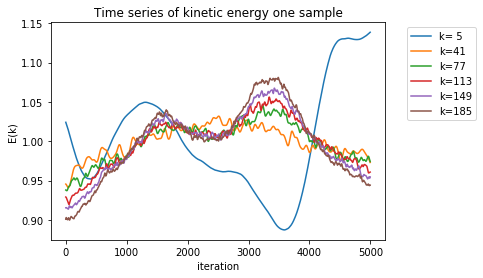

In [13]:
sample_index = 0

norm_coef = np.ndarray(shape=(wavenumbers_length), dtype=float)

for ik in indices_of_k_to_plot :
    if normalization_status :
        norm_coef[ik] = 1/np.mean(energy[:,ik])
    else : 
        norm_coef[ik] = 1
    plt.plot(np.real(samples[sample_index,:,ik])*norm_coef[ik], label='k=%2.f' % (k[ik]/k_norm_coef))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Time series of kinetic energy one sample')
plt.xlabel('iteration'); plt.ylabel("E(k)")
plt.show()

# Export image to pdf
#pp = PdfPages('Images/time_series.pdf')
#pp.savefig()
#pp.close()

## PDF of kinetic energy

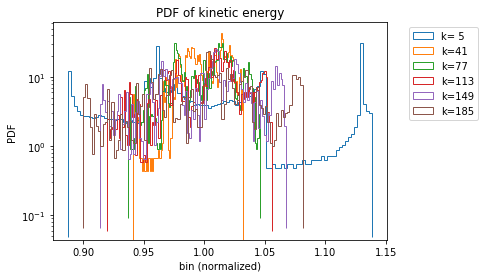

In [14]:
#plot histogram
nb_of_bins=100

for ik in indices_of_k_to_plot :
    plt.hist(x=energy[:,ik]*norm_coef[ik], bins=nb_of_bins, histtype='step', density=True, log=True, align='mid', label='k=%2.f' % (k[ik]/k_norm_coef))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PDF of kinetic energy')
plt.xlabel('bin (normalized)'); plt.ylabel("PDF")
plt.show()

## Mean kinetic energy vs. k

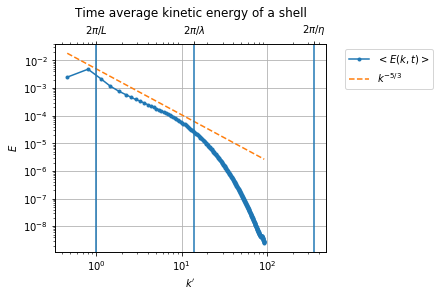

In [15]:
mean_energy = np.mean(energy, axis=0)
    
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k, mean_energy, '.-', label=r'$<E(k,t)>$')
ax.plot(k, 5e-3*k**(-5.0/3.0),'--', label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$E}$', title='Time average kinetic energy of a shell')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

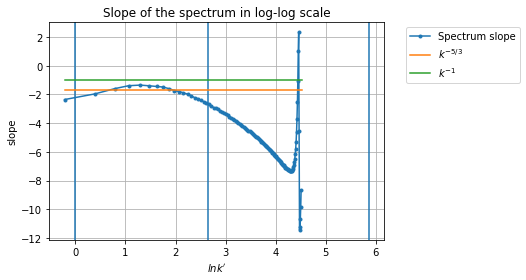

In [16]:
# check the slope of the mean energy
resampling = 2
x = np.log(k[1::resampling])
f = np.log(mean_energy[1::resampling])
slope = np.gradient(f, x)
vertical_lines = np.log(2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta]))
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$k^{-5/3}$')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$k^{-1}$')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
plt.xlabel(r'$ln k^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale'); plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')

## Power spectral density of Ek time signal (using Welch method)

In [17]:
#for ik in list(range(wavenumbers_length)) :
#    y = energy[:,ik]
fs = 1.0/deltaT #sampling frequency

#y = np.sqrt(energy) # Urms
y = energy 
freqs, psd = signal.welch(y, fs, nperseg=2048, axis=0)
omega = 2.0*np.pi*freqs

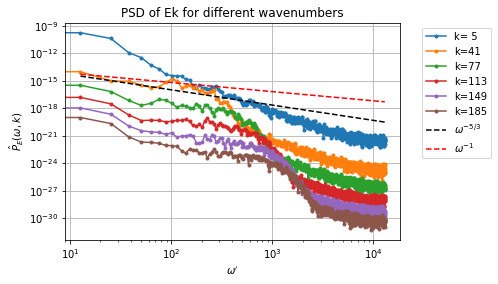

In [18]:
# plot PSD at different k
for ik in indices_of_k_to_plot :
    plt.plot(omega, psd[:,ik], '.-', label='k=%2.f' % (k[ik]/k_norm_coef))
plt.plot(omega[1:-1], 10e-15*freqs[1:-1]**(-5/3), '--k', label=r'$\omega^{-5/3}$')
plt.plot(omega[1:-1], 10e-15*freqs[1:-1]**(-1), '--r', label=r'$\omega^{-1}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\omega^\prime$'); plt.ylabel(r'$\hat{P}_E (\omega, k)$')
plt.title('PSD of Ek for different wavenumbers')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

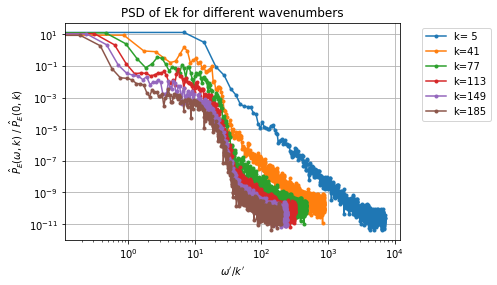

In [19]:
# plot PSD at different k SCALED
for ik in indices_of_k_to_plot :
    vertical_scale = 1.0/psd[0,ik]
    #horizontal_scale = 1.0/k[ik]**(2/3)
    horizontal_scale = 1.0/k[ik]
    plt.plot(omega*horizontal_scale, psd[:,ik]*vertical_scale, '.-', label='k=%2.f' % (k[ik]/k_norm_coef))
# plt.plot(omega[1:-1]*horizontal_scale, 10e-15*freqs[1:-1]**(-5/3), '--k', label=r'$\omega^{-5/3}$')
# plt.plot(omega[1:-1]*horizontal_scale, 10e-15*freqs[1:-1]**(-1), '--r', label=r'$\omega^{-1}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\omega^\prime / k^\prime$'); plt.ylabel(r'$\hat{P}_E (\omega, k) \ / \ \hat{P}_E (0, k)$')
plt.title('PSD of Ek for different wavenumbers')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [20]:
# # check the slope of the psd
# resampling = 2
# x = np.log(omega[1:-1:resampling])
# f = np.log(psd[1:-1:resampling, :])

# for ik in indices_of_k_to_plot :
#     slope = np.gradient(f[:,ik], x)
#     plt.plot(x[:-2:], slope[:-2:], '.-', label='k=%2.f' % (k[ik]/k_norm_coef))
# plt.plot(x[1:-1:], -5/3*np.ones_like(x[1:-1:]), '--k', label=r'$\omega^{-5/3}$')
# plt.plot(x[1:-1:], -1*np.ones_like(x[1:-1:]), '--k',label=r'$\omega^{-1}$')
# plt.plot(x[1:-1:], -7/3*np.ones_like(x[1:-1:]), '--k',label=r'$\omega^{-7/3}$')

# plt.xlabel(r'$ln \omega^\prime$'), plt.ylabel('slope')
# plt.title('Slope of the PSD in log-log scale'); plt.grid()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xscale('linear')
# plt.xlim([1.4, 5]);plt.ylim([-5, 1])
# plt.show()

## Amplitude of PSD at zero freq (w=0)

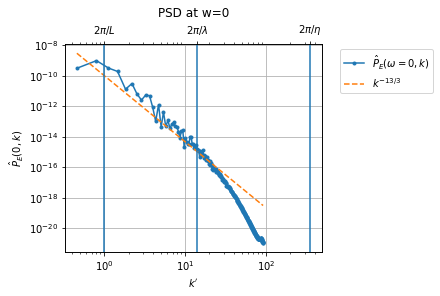

In [21]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k, psd[0,:], '.-', label=r'$\hat{P}_E (\omega=0, k)$')
ax.plot(k, 1e-10*k**(-13.0/3.0),'--', label=r'$k^{-13/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$\hat{P}_E (0, k)$', title='PSD at w=0')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

## Total temporal PSD (sum over k) + kolmogorov & sweeping freq scales

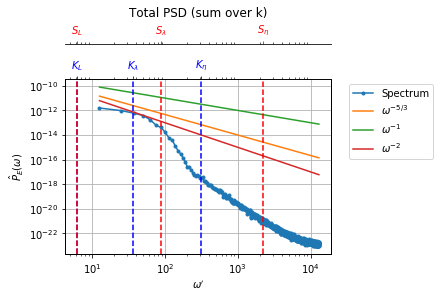

In [22]:
tl = dissipation_rate**(-1/3)*lmbda**(2/3) #Kolmogorov time scale for lambda
teta = dissipation_rate**(-1/3)*eta**(2/3) #Kolmogorov time scale for eta
vertical_lines_kolmogorov = 2*np.pi*np.array([1.0/t0, 1.0/tl, 1.0/teta])*t0
vertical_lines_sweeping = 2*np.pi*2*np.pi*np.array([1.0/L, 1.0/lmbda, 1.0/eta]) * k_norm_coef

fig, ax = plt.subplots(constrained_layout=True)
total_psd = np.zeros(shape=psd.shape[0], dtype=float)
range_of_k = list(range(10,20))
#range_of_k = list(range(wavenumbers_length))
for ik in range_of_k : 
    total_psd = total_psd + psd[:,ik]
total_psd = total_psd/len(range_of_k)
#total_psd = total_psd*4.0e2
ax.plot(omega[1:-1], total_psd[1:-1], '.-', label='Spectrum')
ax.plot(omega[1:-1], 10e-10*omega[1:-1]**(-5.0/3.0),label=r'$\omega^{-5/3}$')
ax.plot(omega[1:-1], 10e-10*omega[1:-1]**(-1.0), label=r'$\omega^{-1}$')
ax.plot(omega[1:-1], 10e-10*omega[1:-1]**(-2.0), label=r'$\omega^{-2}$')
for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$', ylabel=r'$\hat{P}_E (\omega)$', title='Total PSD (sum over k)'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
ax2.tick_params(axis='x', colors='blue')

ax3 = ax.twiny()
ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax3.spines["top"].set_position(("axes", 1.2))
ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
ax3.tick_params(axis='x', colors='red')

plt.show()

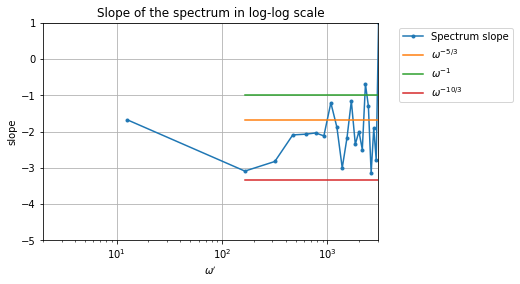

In [23]:
# check the slope of the total psd
resampling = 12
x = np.log(omega[1:-1:resampling])
f = np.log(np.sqrt(total_psd[1:-1:resampling]))
slope = np.gradient(f, x)
plt.plot(np.exp(x[:-2:]), slope[:-2:], '.-', label='Spectrum slope')
plt.plot(np.exp(x[1:-1:]), -5/3*np.ones_like(x[1:-1:]), '-', label=r'$\omega^{-5/3}$')
plt.plot(np.exp(x[1:-1:]), -1*np.ones_like(x[1:-1:]), '-',label=r'$\omega^{-1}$')
plt.plot(np.exp(x[1:-1:]), -10/3*np.ones_like(x[1:-1:]), '-',label=r'$\omega^{-10/3}$')

plt.xlabel(r'$\omega^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale'); plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('log'); plt.yscale('linear')
plt.xlim([2, 3000]); plt.ylim([-5, 1])
plt.show()

## Autocorrelation of the kinetic energy time series

In [24]:
# allocation and initialization
# values in the vector of time lags are non-dimensional
lags = np.array(range(-iterations_per_sample+1,iterations_per_sample))*deltaT
length_lags = lags.shape[0]
autocorrelation_of_sample = np.ndarray(shape=(nb_of_samples, length_lags, wavenumbers_length), dtype=float)

In [25]:
# COMPUTE autocorrelation of each sample
for i in range(nb_of_samples) :
    for ik in range(1, wavenumbers_length) :
        #data_to_correlate = np.sqrt(samples[i,:,ik]) #take urms
        data_to_correlate = samples[i,:,ik] #take energy
        autocorrelation_of_sample[i,:,ik] = signal.correlate(data_to_correlate, data_to_correlate, mode='full', method='fft')
# averaging over all samples
autocorrelation = np.mean(autocorrelation_of_sample, axis=0)
#autocorrelation = autocorrelation_of_sample[0,:,:]

# NORMALIZATION of  the autocorrelation by the value of correlation at the time lag=0
normalization_of_correlation = np.ndarray(shape=(wavenumbers_length), dtype=float)
normalization_of_correlation.fill(1.0)
if normalization_status :
    normalization_of_correlation[1::] = (autocorrelation[lags.shape[0]//2, 1::])**-1     

In [26]:
autocorrelation.shape

(9995, 256)

In [27]:
lags.shape

(9995,)

In [28]:
autocorrelation_of_sample[0,:,10]

array([6.08161010e-08, 1.21636826e-07, 1.82461841e-07, ...,
       1.82461841e-07, 1.21636826e-07, 6.08161010e-08])

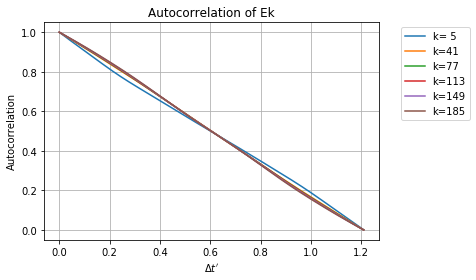

In [29]:
#Plotting area
lag1 = 0
lag2 = 1000

# find the corresponding indexes in the lag vector
a = np.searchsorted(lags, lag1)
b = np.searchsorted(lags, lag2)

#for ik in indices_of_k_to_plot :
for ik in indices_of_k_to_plot :
    plt.plot(lags[a:b], autocorrelation[a:b, ik]*normalization_of_correlation[ik],'-', label='k=%2.f' % (k[ik]/k_norm_coef))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Autocorrelation of Ek'); plt.grid()
plt.xlabel(r'$\Delta t^\prime$'); plt.ylabel('Autocorrelation')
#plt.yscale('log')
plt.show()

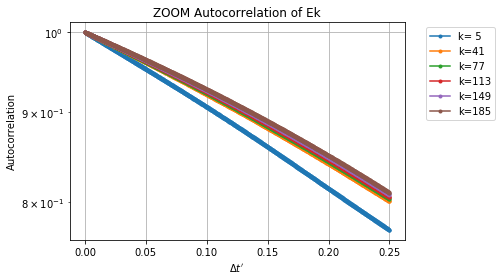

In [30]:
#ZOOM
lag1 = 0.0
lag2 = 0.25

# find the corresponding indexes in the lag vector
a = np.searchsorted(lags, lag1)
b = np.searchsorted(lags, lag2)

for ik in indices_of_k_to_plot :
    plt.plot(lags[a:b], autocorrelation[a:b, ik]*normalization_of_correlation[ik],'.-', label='k=%2.f' % (k[ik]/k_norm_coef))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('ZOOM Autocorrelation of Ek'); plt.grid()
plt.xlabel(r'$\Delta t^\prime$'); plt.ylabel('Autocorrelation')
plt.yscale('log')
plt.show()

### Spatial spectrum from energy autocorrelation (at time lag t = 0)

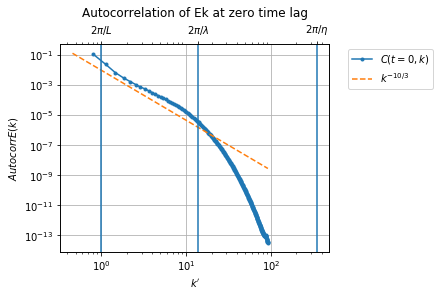

In [31]:
spatial_spectrum1 = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    spatial_spectrum1[ik] = autocorrelation[lags.shape[0]//2, ik] 
    
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k[1::], spatial_spectrum1[1::], '.-', label=r'$C (t=0, k)$')
ax.plot(k, 1e-2*k**(-10.0/3.0),'--', label=r'$k^{-10/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$Autocorr E(k)$', title='Autocorrelation of Ek at zero time lag')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

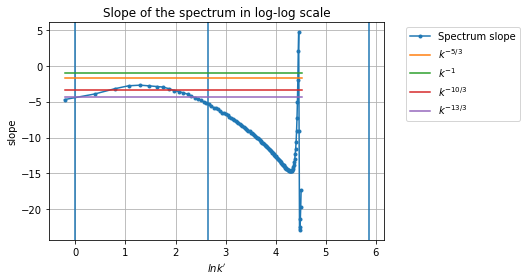

In [32]:
# check the slope of the spectrum
resampling = 2
x = np.log(k[1::resampling])
f = np.log(spatial_spectrum1[1::resampling])
slope = np.gradient(f, x)
vertical_lines = np.log(2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta]))
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-', label=r'$k^{-5/3}$')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-',label=r'$k^{-1}$')
plt.plot(x[:-1:], -10/3*np.ones_like(x[:-1:]), '-',label=r'$k^{-10/3}$')
plt.plot(x[:-1:], -13/3*np.ones_like(x[:-1:]), '-',label=r'$k^{-13/3}$')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
plt.xlabel(r'$ln k^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale'); plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')

### FFT in time of the energy autocorrelation (according to Wiener-Khinchin theorem must coincide with PSD of the time series)

In [33]:
# compute time spectrum of autocorrelation

# IMPORTANT : python fft implies that first element of the x vector is ZERO (if it is not the case one needs to apply a phase shift in the spectral space)
if (length_lags % 2 == 0) :
    # if even
    x = lags[length_lags//2::]    #take only the positive time lags part of the autocorrelations
    y = autocorrelation[length_lags//2::,:]
else : 
    # if odd
    x = lags[length_lags//2::]
    y = autocorrelation[length_lags//2::,:]
print('First element in x-vector : ', x[0])
print('Length of x vector : ', x.shape[0])

delta = x[1]-x[0]

omega = 2*np.pi*np.fft.fftfreq(x.shape[0], delta)
omega = omega[:omega.shape[0]//2+1:]

time_spectrum = np.ndarray(shape=(x.shape[0]//2+1, wavenumbers_length), dtype=complex)
#time_spectrum = np.ndarray(shape=(x.shape[0], wavenumbers_length), dtype=complex)

for ik in list(range(wavenumbers_length)) :
    time_spectrum[:, ik] = 1.0/length_lags*np.fft.rfft(y[:,ik])
    
# time_spectrum_of_sample = np.ndarray(shape=(nb_of_samples, N, wavenumbers_length), dtype=complex)
# for index_sample in list(range(nb_of_samples)) :
#     for ik in list(range(wavenumbers_length)) :
#         yf = np.fft.fft(autocorrelation_of_sample[i,:, ik])
#         time_spectrum_of_sample[index_sample, :, ik] = 1.0/N*np.fft.fftshift(yf)
# time_spectrum = np.mean(time_spectrum_of_sample, axis=0)

First element in x-vector :  0.0
Length of x vector :  4998


In [34]:
omega.shape

(2500,)

In [35]:
time_spectrum.shape

(2500, 256)

### Amplitude of zero frequency (w = 0)

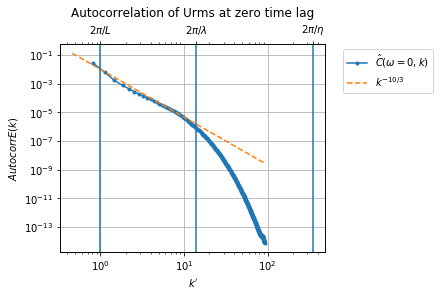

In [36]:
zero_amp1 = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    zero_amp1[ik] = np.absolute(time_spectrum[0, ik])
    
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k[1::], zero_amp1[1::], '.-', label=r'$\hat{C} (\omega=0, k)$')
ax.plot(k, 1e-2*k**(-10.0/3.0),'--', label=r'$k^{-10/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$Autocorr E(k)$', title='Autocorrelation of Urms at zero time lag')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

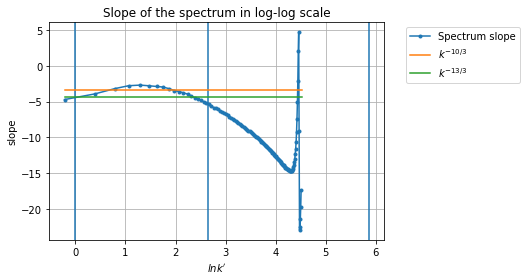

In [37]:
# check the slope of the spectrum
resampling = 2
x = np.log(k[1::resampling])
f = np.log(zero_amp1[1::resampling])
slope = np.gradient(f, x)
vertical_lines = np.log(2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta]))
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -10/3*np.ones_like(x[:-1:]), '-', label=r'$k^{-10/3}$')
plt.plot(x[:-1:], -13/3*np.ones_like(x[:-1:]), '-',label=r'$k^{-13/3}$')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
plt.xlabel(r'$ln k^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale'); plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')

### Time spectrum of energy autocorrelation at different k

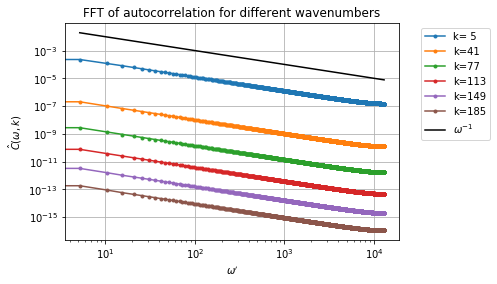

In [38]:
#plot
for ik in indices_of_k_to_plot :
    #vertical_scale = 1.0/np.absolute(time_spectrum[0,ik])
    vertical_scale = 1.0
    #horizontal_scale = 1.0/(k[ik]*L)
    horizontal_scale = 1.0
    plt.plot(omega[:-1]*horizontal_scale, np.absolute(time_spectrum[:-1,ik]*vertical_scale), '.-', label='k=%2.f' % (k[ik]/k_norm_coef))
#plt.xlim(-15, 15) 
plt.plot(omega[1:-1:]*horizontal_scale, 10e-2*omega[1:-1:]**(-1), 'k-', label=r'$\omega^{-1}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\omega^\prime$'); plt.ylabel(r'$\hat{C} (\omega, k)$')
plt.title('FFT of autocorrelation for different wavenumbers')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Total time spectrum (sum over k)

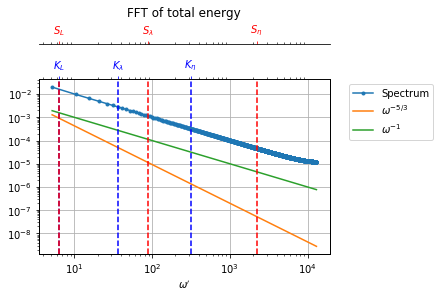

In [39]:
tl = dissipation_rate**(-1/3)*lmbda**(2/3) #Kolmogorov time scale for lambda
teta = dissipation_rate**(-1/3)*eta**(2/3) #Kolmogorov time scale for eta
vertical_lines_kolmogorov = 2*np.pi*np.array([1.0/t0, 1.0/tl, 1.0/teta])*t0
vertical_lines_sweeping = 2*np.pi*2*np.pi*np.array([1.0/L, 1.0/lmbda, 1.0/eta]) * k_norm_coef

fig, ax = plt.subplots(constrained_layout=True)
total_correlation_spectrum = np.zeros(shape=time_spectrum.shape[0], dtype=float)
range_of_k = list(range(wavenumbers_length))
for ik in range_of_k : 
    spectrum = np.absolute(time_spectrum[:, ik])
    total_correlation_spectrum = total_correlation_spectrum + spectrum 
total_correlation_spectrum = total_correlation_spectrum/len(range_of_k)
total_correlation_spectrum = total_correlation_spectrum*4.0e2
ax.plot(omega[1:-1], total_correlation_spectrum[1:-1], '.-', label='Spectrum')
ax.plot(omega[1:-1], 2.0e-2*omega[1:-1]**(-5.0/3.0),label=r'$\omega^{-5/3}$')
ax.plot(omega[1:-1], 10e-3*omega[1:-1]**(-1.0), label=r'$\omega^{-1}$')
for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
ax.set(xscale='log', yscale='log', xlabel=r'$\omega^\prime$', title='FFT of total energy'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
ax2.tick_params(axis='x', colors='blue')

ax3 = ax.twiny()
ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax3.spines["top"].set_position(("axes", 1.2))
ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
ax3.tick_params(axis='x', colors='red')

plt.show()

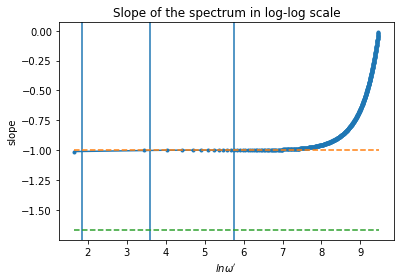

In [40]:
# check the slope of the spectrum
resampling = 5
x = np.log(omega[1:-1:resampling])
f = np.log(total_correlation_spectrum[1:-1:resampling])
slope = np.gradient(f, x)
vertical_lines=np.log(vertical_lines_kolmogorov)
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '--',label=r'$\omega^{-5/3}$')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '--', label=r'$\omega^{-1}$')
plt.xlabel(r'$ln \omega^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale')
plt.xscale('linear')

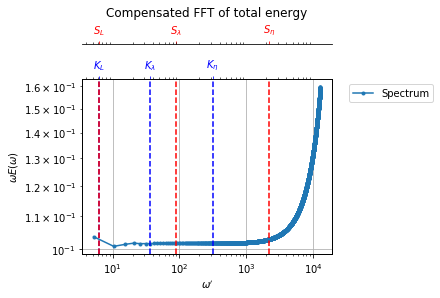

In [41]:
# compensate total spectrum by w^1

compensated_total_correlation_spectrum = np.multiply(total_correlation_spectrum,omega)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(omega[1:-1], compensated_total_correlation_spectrum[1:-1], '.-', label='Spectrum')

ax.set(xscale='log', yscale='linear', xlabel=r'$\omega^\prime$', ylabel=r'$\omega E(\omega)$', title='Compensated FFT of total energy'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for line in vertical_lines_kolmogorov : ax.axvline(x=line, c='blue', ls='--') #ax2
for line in vertical_lines_sweeping : ax.axvline(x=line, c='red', ls='--') #ax3
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines_kolmogorov); ax2.set_xticklabels([r'$K_L$', r'$K_\lambda$', r'$K_\eta$'])
ax2.tick_params(axis='x', colors='blue')

ax3 = ax.twiny()
ax3.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax3.spines["top"].set_position(("axes", 1.2))
ax3.set_xticks(vertical_lines_sweeping); ax3.set_xticklabels([r'$S_L$', r'$S_\lambda$', r'$S_\eta$'])
ax3.tick_params(axis='x', colors='red')

plt.show()

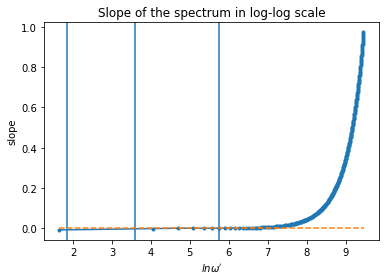

In [42]:
# check the slope of the compensated spectrum
resampling = 10
x = np.log(omega[1:-1:resampling])
f = np.log(compensated_total_correlation_spectrum[1:-1:resampling])
slope = np.gradient(f, x)
vertical_lines=np.log(vertical_lines_kolmogorov)
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], 0.0*np.ones_like(x[:-1:]), '--',label=r'$\omega^{-5/3}$')
plt.xlabel(r'$ln \omega^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale')
plt.xscale('linear')

### Total spatial spectrum (sum over w)

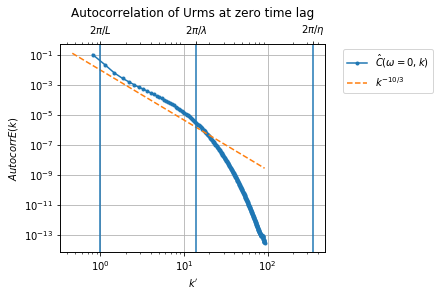

In [43]:
total_spat_spec = np.sum(np.absolute(time_spectrum), axis=0)
    
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k[1::], total_spat_spec[1::], '.-', label=r'$\hat{C} (\omega=0, k)$')
ax.plot(k, 1e-2*k**(-10.0/3.0),'--', label=r'$k^{-10/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k^\prime$', ylabel=r'$Autocorr E(k)$', title='Autocorrelation of Urms at zero time lag')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

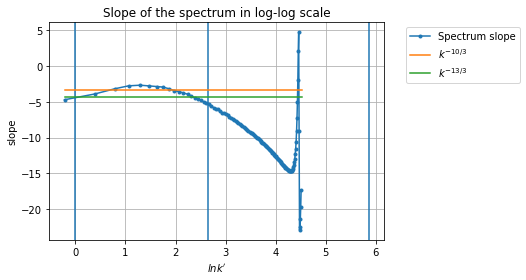

In [44]:
# check the slope of the spectrum
resampling = 2
x = np.log(k[1::resampling])
f = np.log(total_spat_spec[1::resampling])
slope = np.gradient(f, x)
vertical_lines = np.log(2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta]))
for line in vertical_lines : plt.axvline(x=line)
plt.plot(x[:-2:], slope[:-2:], '.-', label='Spectrum slope')
plt.plot(x[:-1:], -10/3*np.ones_like(x[:-1:]), '-', label=r'$k^{-10/3}$')
plt.plot(x[:-1:], -13/3*np.ones_like(x[:-1:]), '-',label=r'$k^{-13/3}$')
vertical_lines = 2.0*np.pi* k_norm_coef *np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
plt.xlabel(r'$ln k^\prime$'), plt.ylabel('slope')
plt.title('Slope of the spectrum in log-log scale'); plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xscale('linear')